In [2]:
# 1. magic for inline plot
# 2. magic to print version
# 3. magic so that the notebook will reload external python modules
# 4. magic to enable retina (high resolution) plots
# https://gist.github.com/minrk/3301035
%matplotlib inline
%load_ext watermark
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%watermark -a 'Ethen' -d -t -v -p numpy,pandas,sklearn,matplotlib

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Ethen 2018-07-04 13:08:17 

CPython 3.6.4
IPython 6.4.0

numpy 1.14.5
pandas 0.23.0
sklearn 0.19.1
matplotlib 2.2.2


# Supervised Time Series

The gist behind time series analysis is that we are given some quantitative measures about the past and we wish to use these informations to predict the future to enable better planning, decision-making and so on. The main difference between time series problem and traditional prediction problems is that: in traditional prediction problems such as image classification, the data points there are assumed to be independent of one another. Whereas, time series analysis' data points have a temporal nature in them, i.e. The time dimension adds an explicit ordering to our data points that should be preserved because they can provide additional/important information to the learning algorithms.

This is not to say machine learning methods like supervised learning can't be used for time series forecasting, but before we apply these supervised learning methods on our time series data, we need to do some preprocessing step to make them applicable. The approach we will be discussing here is called the **sliding window**.

Given a sequence of numbers for a time series dataset, we can restructure the data to look like a supervised learning problem by using previous time steps as input variables and the next time step as the output variable. Let's make this concrete with an example. Imagine we have a time series as follows:

```
time, measure
1, 100
2, 110
3, 108
4, 115
5, 120
```

Given the original data above, we can re-frame into a format that's applicable for a supervised learning model:

```
X, y
?, 100
100, 110
110, 108
108, 115
115, 120
120, ?
```

- The second row of the data shows that our input variable X is the measure at time 1 and our target variable y is the measure at time 2.
- We can see that the order between the observations is preserved, and must continue to be preserved when using this dataset to train a supervised model.
- Because we have no previous value that we can use to predict the first value in the sequence, we will need to delete this record. The same goes for the last value in the sequence (we do not have a known next value to predict for).


The use of prior time steps to predict the next time step is called the sliding window method. Note that it might also be refer to as the lag method. And the number of previous time steps to look at is called the window width or size of the lag. In the example above, we are using a window size of 1.

This sliding window approach forms the basis for how we can turn any time series dataset into a supervised learning problem and it can also be used on a time series that has more than one value, or so-called **multivariate time series**. An example of this is shown below:

Let's assume we have the contrived multivariate time series dataset below with two observed features at each time step. And we are concerned with predicting measure2. Then we would go from:

```
time, measure1, measure2
1, 0.2, 88
2, 0.5, 89
3, 0.7, 87
4, 0.4, 88
5, 1.0, 90
```

to:

```
X1, X2, y
?, ?, 88
0.2, 88, 89
0.5, 89, 87
0.7, 87, 88
0.4, 88, 90
1.0, 90, ?
```

## Implementation

A key function to help transform time series data into a supervised learning problem is the pandas `shift()` function. Given a DataFrame, the `shift()` (some other libraries calls it `lag`) function can be used to create copies of columns that are pushed forward or pushed backward. This operation is required to create columns of lag observations as well as columns of forecast observations for a time series dataset in a supervised learning format.

Let’s look at some examples of the shift function in action. We start off by defining a toy time series dataset as a sequence of 10 numbers then use the shift function to create the "lagged" time series.

In [4]:
df = pd.DataFrame()
df['t'] = [x for x in range(10)]

# shift all the observations up by one time step
df['t+1'] = df['t'].shift(-1)
df

,t,t+1
0,0,1.0
1,1,2.0
2,2,3.0
3,3,4.0
4,4,5.0
5,5,6.0
6,6,7.0
7,7,8.0
8,8,9.0
9,9,NaN


Running the code chunk above gives us two columns in the dataset. The first contains the original observations and the second has the shifted observation. Note that the last row would have to be discarded because of the NaN value (there's no value to shift up).

From the output above, we can see that shifting the series forward one time step gives us a primitive supervised learning problem, where the first row shows the input value of 0.0 corresponding to the output of the second column 1.0.

In [5]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

values = [x for x in range(10)]
data = series_to_supervised(values)
print(data)

   var1(t-1)  var1(t)
1        0.0        1
2        1.0        2
3        2.0        3
4        3.0        4
5        4.0        5
6        5.0        6
7        6.0        7
8        7.0        8
9        8.0        9


In [9]:
input_path = 'PRSA_data_2010.1.1-2014.12.31.csv'
df = pd.read_csv(input_path)
print('dimension: ', df.shape)
df.head()

dimension:  (43824, 13)


,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [11]:
from datetime import datetime

def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

input_path = 'PRSA_data_2010.1.1-2014.12.31.csv'
dataset = pd.read_csv(input_path, parse_dates = {'date': ['year', 'month', 'day', 'hour']},
                      index_col=0, date_parser=parse)

dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
dataset.head(5)

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


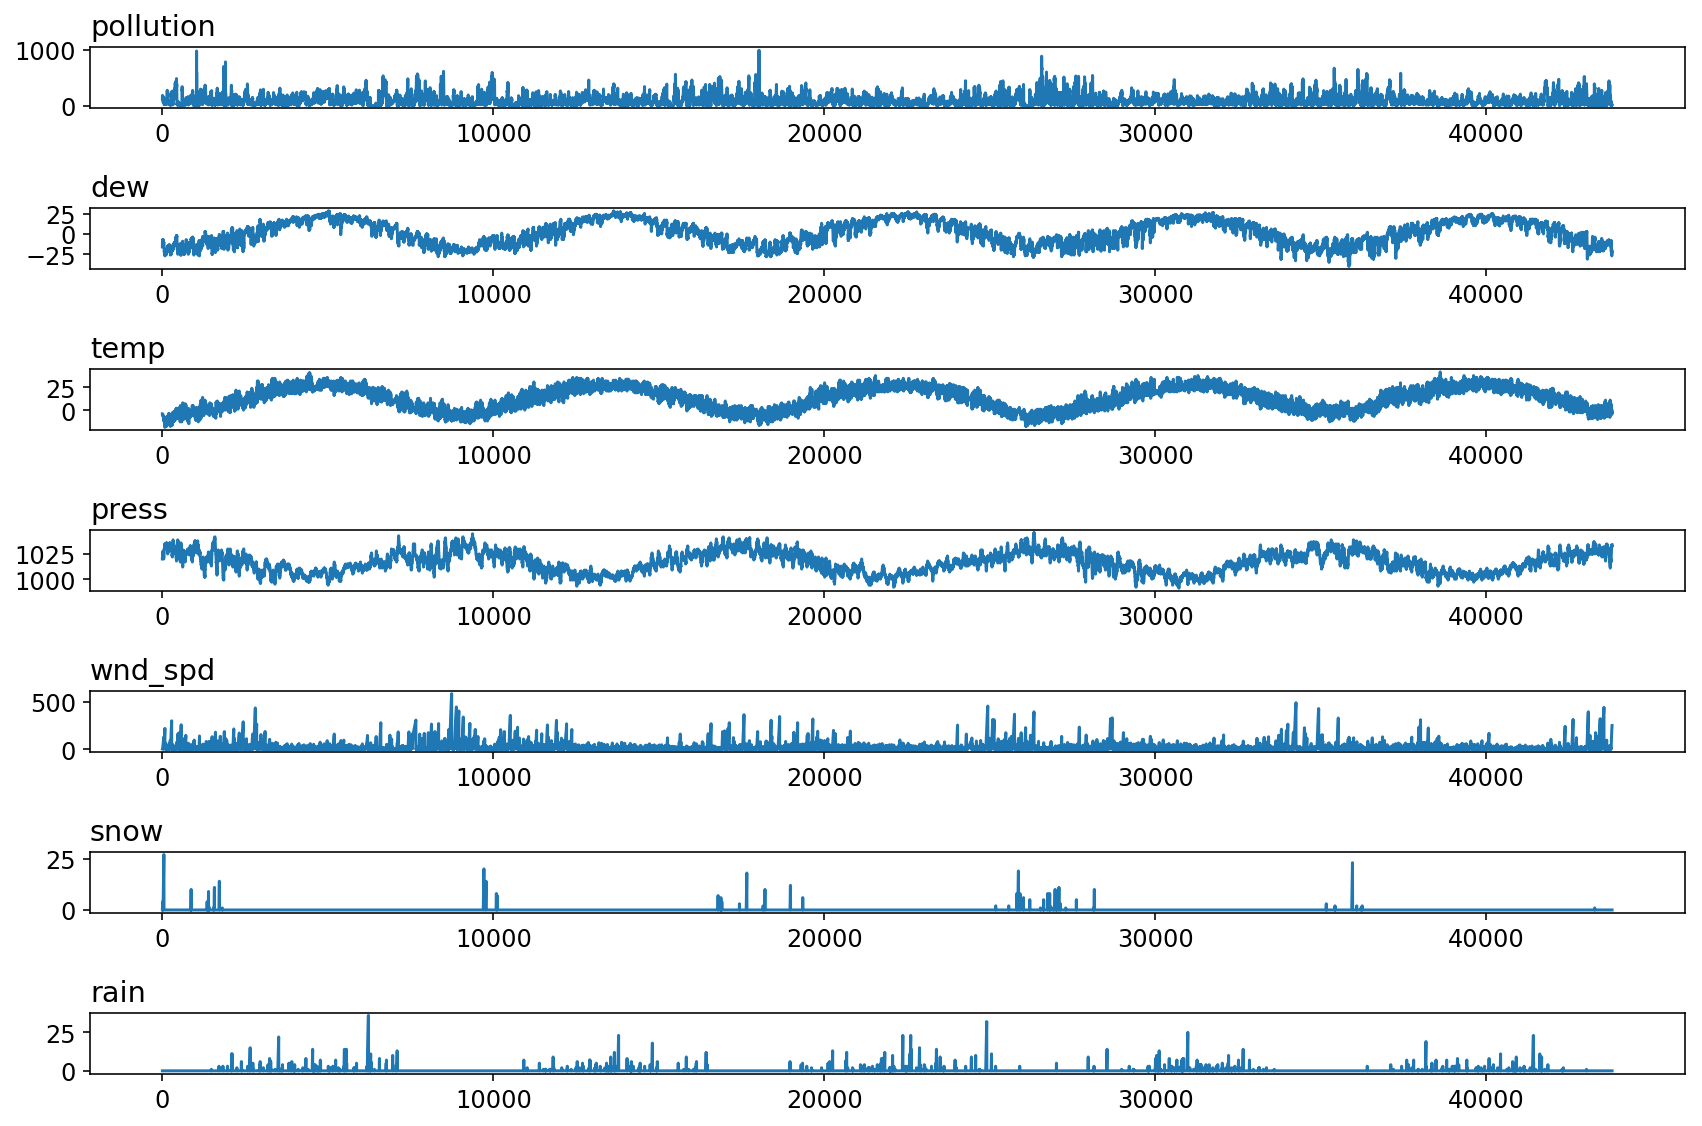

In [25]:
# change default style figure and font size
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12

# we won't be plotting the wind direction variable
plot_features = ['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain']
n_features = len(plot_features)

fig = plt.figure(figsize=(12, 8))
for i, col in enumerate(plot_features):
    plt.subplot(n_features, 1, i + 1)
    plt.plot(dataset[col].values)
    plt.title(col, loc='left')

plt.tight_layout()
plt.show()

LSTMs are much newer/younger to solve /simpler/ AR problems – most industries have already been studying and improving custom models applied on such tasks for decades. I believe RNNs shine for multivariate time series forecasts, that have been simply too difficult to model until now. Similarly with MLPs and multivariate time series models where the different features can have different forecasting powers(ie the sentiment of twitter posts can have influence for a day or two, while ny times articles could have a much longer lasting influence).

# Reference

- [Blog: Time Series Forecasting as Supervised Learning](https://machinelearningmastery.com/time-series-forecasting-supervised-learning/)
- [Blog: How to Convert a Time Series to a Supervised Learning Problem in Python](http://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/)